In [39]:
import numpy as np

from eigen import eigen
from grid import FVGrid
from reconstruction import PPMInterpolant
import riemann_exact as re

In [40]:
class FluidVars:
    """A simple container that holds the integer indicies we will use to
    refer to the different fluid components"""
    def __init__(self):
        self.nvar = 3
    
        # conserved variables
        self.urho = 0
        self.umx = 1
        self.uener = 2
    
        # primitive variables
        self.qrho = 0
        self.qu = 1
        self.qp = 2

In [53]:
class Euler:
    def __init__(self, nx, C, *,
                 gamma=1.4, init_cond=None):

        self.grid = FVGrid(nx, ng=4, bc_type="outflow")
        self.v = FluidVars()
        
        self.C = C
        self.gamma = gamma
        
        # storage for the current solution
        self.U = self.grid.scratch_array(nc=self.v.nvar)

        # initialize
        init_cond(self.grid, self.v, self.gamma, self.U)

        self.t = 0
        self.dt = np.nan
        
    def estimate_dt(self):

        q = self.cons_to_prim()
        cs = np.sqrt(self.gamma * q[:, self.v.qp] / q[:, self.v.qrho])

        self.dt = self.C * self.grid.dx / np.max(np.abs(q[:, self.v.qu]) + cs)

    def cons_to_prim(self):
        q = self.grid.scratch_array(nc=self.v.nvar)
        
        q[:, self.v.qrho] = self.U[:, self.v.urho]
        q[:, self.v.qu] = self.U[:, self.v.umx] / self.U[:, self.v.urho]
        
        rhoe = self.U[:, self.v.uener] - 0.5 * q[:, self.v.qu]**2
        q[:, self.v.qp] = rhoe * (self.gamma - 1.0)
        
        return q

    def interface_states(self):

        # convert to primitive variables
        q = self.cons_to_prim()
        cs = np.sqrt(self.gamma * q[:, self.v.qp] / q[:, self.v.qrho])
        
        # compute flattening

        # construct parabola
        rho_pb = PPMInterpolant(self.grid, q[:, self.v.qrho])
        u_pb = PPMInterpolant(self.grid, q[:, self.v.qu])
        p_pb = PPMInterpolant(self.grid, q[:, self.v.qp])

        # integrate over the 3 waves
        Ip_rho = self.grid.scratch_array(nc=3)
        Im_rho = self.grid.scratch_array(nc=3)

        Ip_u = self.grid.scratch_array(nc=3)
        Im_u = self.grid.scratch_array(nc=3)

        Ip_p = self.grid.scratch_array(nc=3)
        Im_p = self.grid.scratch_array(nc=3)

        for iwave, sgn in enumerate([-1, 0, 1]):
            sigma = q[:, self.v.qu] + sgn * cs

            Im_rho[:, iwave], Ip_rho[:, iwave] = rho_pb.integrate(sigma)
            Im_u[:, iwave], Ip_u[:, iwave] = u_pb.integrate(sigma)
            Im_p[:, iwave], Ip_p[:, iwave] = p_pb.integrate(sigma)

        # loop over zones -- we will construct the state on
        # the left and right sides of this zone, these are
        # q_{i,r} and q_{i+1,l}

        # from the perspective of the zone, the subscript
        # p means toward the right edge of the zone and m
        # means toward the left edge of the zone

        # from the perspective of an interface, the subscript
        # left means to the left of the interface and right
        # means to the right of the interface
        
        q_left = self.grid.scratch_array(nc=self.v.nvar)
        q_right = self.grid.scratch_array(nc=self.v.nvar)
        
        for i in range(self.grid.lo-1, self.grid.hi+2):

            rz = q[i, self.v.qrho]
            uz = q[i, self.v.qu]
            pz = q[i, self.v.qp]
            
            # build eigensystem
            ev, lvec, rvec = eigen(rz, uz, pz, self.gamma)

            # reference states -- fastest wave moving to the left or right
            q_ref_m = np.array([Im_rho[i, 0], Im_u[i, 0], Im_p[i, 0]])
            q_ref_p = np.array([Ip_rho[i, 2], Ip_u[i, 2], Ip_p[i, 2]])
            
            # trace states
            beta_xm = np.zeros(3)            
            beta_xp = np.zeros(3)

            # loop over waves and compute l . (qref - I) for each wave
            for iwave in range(3):
                beta_xm[iwave] = lvec[iwave, :] @ (q_ref_m - np.array([Im_rho[i, iwave], Im_u[i, iwave], Im_p[i, iwave]]))
                beta_xp[iwave] = lvec[iwave, :] @ (q_ref_p - np.array([Ip_rho[i, iwave], Ip_u[i, iwave], Ip_p[i, iwave]]))

            # finally sum up the waves moving toward the interface, accumulating (l . (q_ref - I)) r
            q_left[i+1, :] = q_ref_p[:]
            q_right[i, :] = q_ref_m[:]
            for iwave in range(3):
                if ev[iwave] >= 0:
                    q_left[i+1, :] += beta_xp[iwave] * rvec[iwave, :]
                if ev[iwave] <= 0:
                    q_right[i, :] += beta_xm[iwave] * rvec[iwave, :]

        return q_left, q_right

    def cons_flux(self, state):
        """ given an interface state, return the conservative flux"""
        flux = np.zeros((self.v.nvar), dtype=np.float64)

        flux[self.v.urho] = state.rho * state.u
        flux[self.v.umx] = flux[self.v.urho] * state.u + state.p
        flux[self.v.uener] = (0.5 * state.rho * state.u**2 +
                        state.p/(self.gamma - 1.0) + state.p) * state.u
        return flux
        
    def advance_step(self):

        # construct interface states
        q_left, q_right = self.interface_states()
        
        # solve Riemann problem and compute fluxes
        # this is a loop over interfaces

        flux = self.grid.scratch_array(nc=self.v.nvar)
        
        for i in range(self.grid.lo, self.grid.hi+2):
            sl = re.State(rho=q_left[i, self.v.qrho], u=q_left[i, self.v.qu], p=q_left[i, self.v.qp])
            sr = re.State(rho=q_right[i, self.v.qrho], u=q_right[i, self.v.qu], p=q_right[i, self.v.qp])
            rp = re.RiemannProblem(sl, sr, gamma=self.gamma)
            rp.find_star_state()
            s_int = rp.sample_solution()
            flux[i, :] = self.cons_flux(s_int)

        # conservative update
        # this is a loop over zones

        for i in range(self.grid.lo, self.grid.hi+1):
            self.U[i, :] += self.dt * (flux[i, :] - flux[i+1, :]) / self.grid.dx

    def evolve(self, tmax):

        while (self.t < tmax):

            # fill ghost cells
            self.grid.fill_BCs(self.U)
            
            # get the timestep
            self.estimate_dt()

            if (self.t + self.dt > tmax):
                self.dt = tmax - self.t
                
            # advance
            self.advance_step()
            self.t += self.dt

In [54]:
def sod(g, v, gamma, U):
    
    # setup initial conditions -- this is Sod's problem
    rho_l = 1.0
    u_l = 0.0
    p_l = 1.0
    rho_r = 0.125
    u_r = 0.0
    p_r = 0.1

    idx_l = g.x < 0.5
    idx_r = g.x >= 0.5

    U[idx_l, v.urho] = rho_l
    U[idx_l, v.umx] =  rho_l * u_l
    U[idx_l, v.uener] = p_l/(gamma - 1.0) + 0.5 * rho_l * u_l**2

    U[idx_r, v.urho] = rho_r
    U[idx_r, v.umx] =  rho_r * u_r
    U[idx_r, v.uener] = p_r/(gamma - 1.0) + 0.5 * rho_r * u_r**2

In [61]:
e = Euler(64, 0.5, init_cond=sod)

In [62]:
e.evolve(0.2)

In [63]:
import matplotlib.pyplot as plt

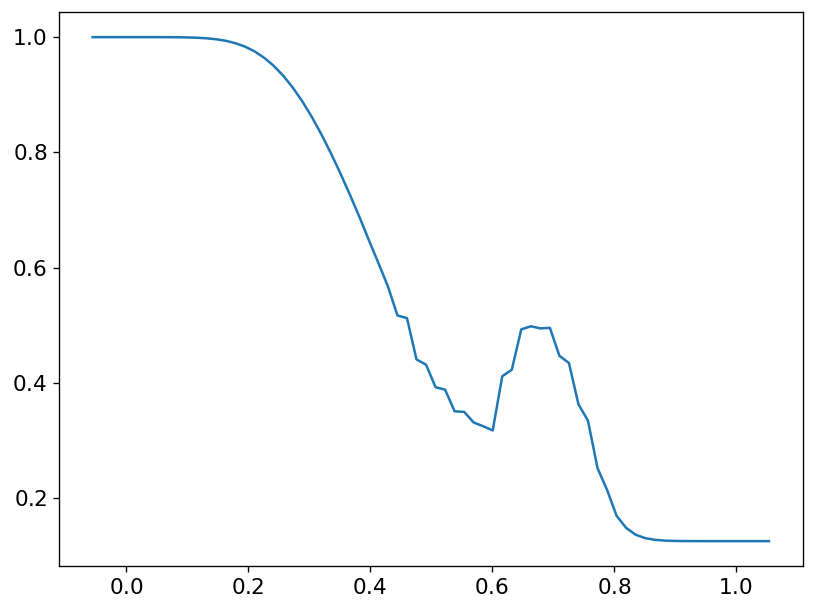

In [64]:
fig, ax = plt.subplots()
ax.plot(e.grid.x, e.U[:, 0])